# 编程题

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from autograd import grad, hessian
plt.rcParams['font.sans-serif'] = 'SimHei'
plt.rcParams['axes.unicode_minus'] = False

## HW2

### （1）黄金分割

In [2]:
def f_1(x):
    y = np.exp(-x)+x**2
    return y

def golden_section(func, x_left, x_right, L):
    alpha = (np.sqrt(5)-1)/2
    while x_right-x_left > L:
        new_x_left = x_left + (1-alpha)*(x_right-x_left)
        new_x_right = x_left + alpha*(x_right-x_left)
        new_y_left = func(new_x_left)
        new_y_right = func(new_x_right)
        if new_y_left <= new_y_right:
            x_right = new_x_right
        else:
            x_left = new_x_left
    print("区间长度为：", x_right-x_left)
    print("区间左端值为{}，区间右端值为{}".format(x_left, x_right))
    print("区间左端函数值为{}，区间右端函数值为{}".format(func(x_left), func(x_right)))
    return x_left, x_right

x_left_last, x_right_last = golden_section(func=f_1, x_left=0, x_right=1, L=1e-6)
print('最优解约为：{}，最优值约为：{}'.format((x_left_last+x_right_last)/2, f_1((x_left_last+x_right_last)/2)))

区间长度为： 8.696778974193187e-07
区间左端值为0.351733436430342，区间右端值为0.3517343061082394
区间左端函数值为0.8271840261276264，区间右端函数值为0.8271840261280027
最优解约为：0.3517338712692907，最优值约为：0.8271840261275589


### （2）梯度下降 回退线搜索

In [3]:
def rosenbrock(x):
    x1 = x[0]
    x2 = x[1]
    y = 100*(x2-x1**2)**2+(1-x1)**2
    return y

def back_search(func, x, d, step, beta=0.8, c=0.5):
    grad_f = grad(func)
    while func(x+step*d) >= func(x)+c*step*np.dot(grad_f(x).T, d):
        step = step*beta
    return step

def gradient_descent_back(func, x, epsilon=1e-4, search_step=1, search_beta=0.8, search_c=0.5):
    grad_f = grad(func)
    x_list = [x]
    y_list = [func(x)]
    while np.linalg.norm(grad_f(x)) >= epsilon:
        d = -grad_f(x)
        step = back_search(func=func ,x=x, d=d, step=search_step, beta=search_beta, c=search_c)
        # print(step)
        x = x + step*d
        x_list.append(x)
        y_list.append(func(x))
    return x_list, y_list

x0 = np.array([-2.0, -2.0])

x_list, y_list =  gradient_descent_back(func=rosenbrock, x=x0)

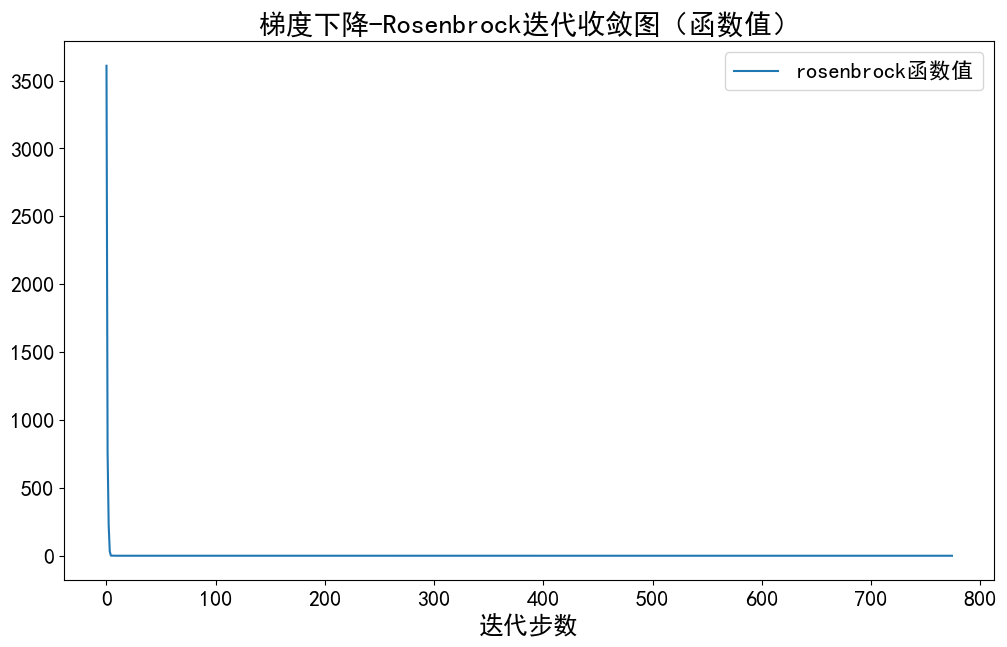

In [4]:
fig = plt.figure(figsize=(12, 7))
plt.plot(y_list)
plt.title("梯度下降-Rosenbrock迭代收敛图（函数值）", fontsize=20)
plt.xlabel("迭代步数", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(['rosenbrock函数值'], fontsize=16)
plt.savefig('pic/gd_y.png', dpi=1000, bbox_inches='tight')

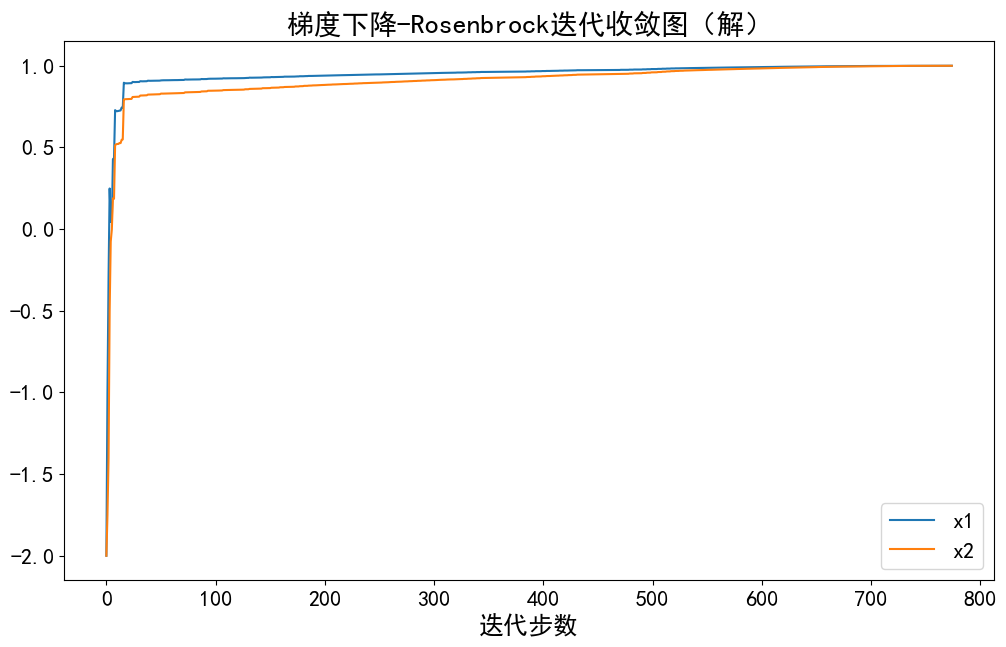

In [5]:
fig = plt.figure(figsize=(12, 7))
plt.plot(x_list)
plt.title("梯度下降-Rosenbrock迭代收敛图（解）", fontsize=20)
plt.xlabel("迭代步数", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(['x1', 'x2'], fontsize=16)
plt.savefig('pic/gd_x.png', dpi=1000, bbox_inches='tight')

### （3）拟牛顿 BFGS

In [6]:
def bfgs(func, x, B, epsilon=1e-4):
    grad_f = grad(func)
    x_list = [x]
    y_list = [func(x)]
    while np.linalg.norm(grad_f(x)) >= epsilon:
        # print(func(x))
        g = grad_f(x)
        # print(B)
        B_inv = np.linalg.inv(B)
        p = -np.dot(B_inv, g)
        step = back_search(func=func, x=x, d=p, step=1)
        new_x = x + step*p
        s = (new_x - x).reshape((len(x), 1))
        # print(len(x))
        y = (grad_f(new_x) - g).reshape((len(x), 1))
        new_B = B - (np.dot(np.dot(np.dot(B, s), s.T), B))/(np.dot(np.dot(s.T, B), s)) + (np.dot(y, y.T))/(np.dot(y.T, s))
        B = new_B
        x = new_x
        x_list.append(x)
        y_list.append(func(x))
    return x_list, y_list

B0 = np.eye(2)
x_list_BFGS, y_list_BFGS = bfgs(func=rosenbrock, x=x0, B=B0)


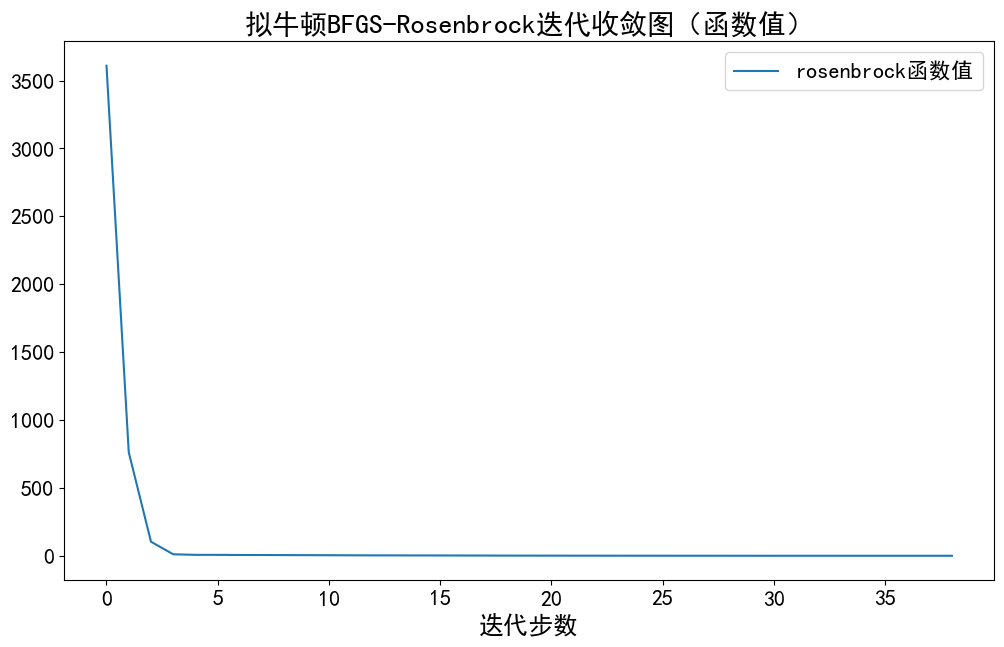

In [7]:
fig = plt.figure(figsize=(12, 7))
plt.plot(y_list_BFGS)
plt.title("拟牛顿BFGS-Rosenbrock迭代收敛图（函数值）", fontsize=20)
plt.xlabel("迭代步数", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(['rosenbrock函数值'], fontsize=16)
plt.savefig('pic/bfgs_y.png', dpi=1000, bbox_inches='tight')

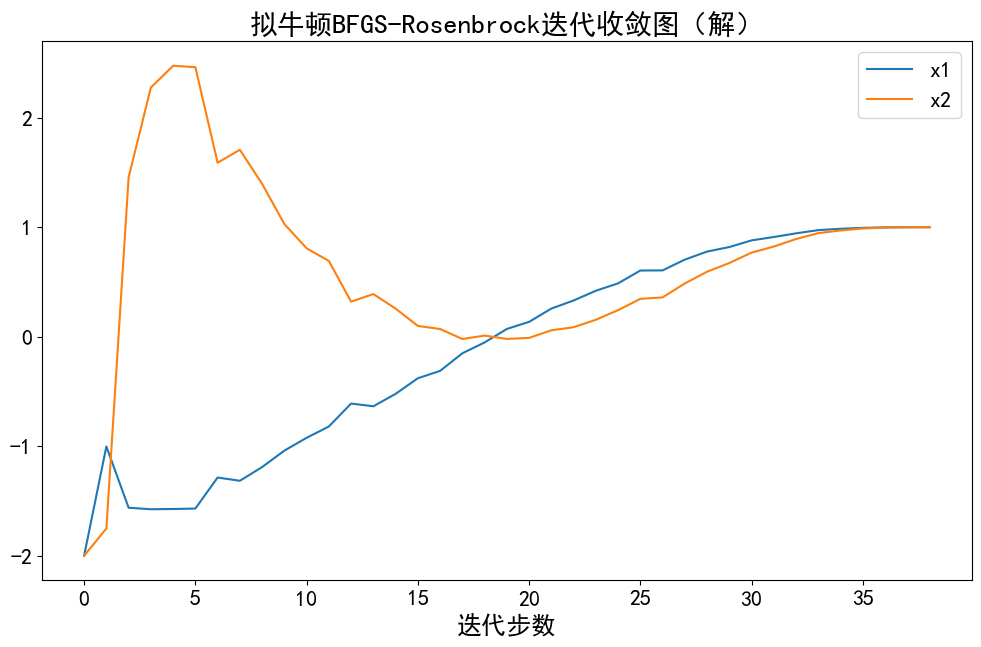

In [8]:
fig = plt.figure(figsize=(12, 7))
plt.plot(x_list_BFGS)
plt.title("拟牛顿BFGS-Rosenbrock迭代收敛图（解）", fontsize=20)
plt.xlabel("迭代步数", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(['x1', 'x2'], fontsize=16)
plt.savefig('pic/bfgs_x.png', dpi=1000, bbox_inches='tight')

### （4）Dogleg

In [9]:
def m_k(func, x, p):
    f = func(x)
    grad_f = grad(func)
    hessian_f = hessian(func)
    g = grad_f(x)
    B = hessian_f(x)
    y = f + g@p + p.T@B@p/2
    return y

def dogleg(func, x, delta):
    grad_f = grad(func)
    hessian_f = hessian(func)
    B = hessian_f(x)
    B_inv = np.linalg.inv(B)
    g = grad_f(x)

    pb = -B_inv@g.T
    pu = -((g@g.T)/(g@B@g.T))*g
    pb_u = pb - pu
    pb_norm = np.linalg.norm(pb)
    pu_norm = np.linalg.norm(pu)
    pb_u_norm = np.linalg.norm(pb_u)

    if pb_norm <= delta:
        tau = 2
    elif pu_norm >= delta:
        tau = delta/pu_norm
    else:
        factor = (pu.T@pb_u)**2
        tau = -pu.T@pb_u + np.sqrt(factor - pb_u_norm**2*(pu_norm**2-delta**2))
        tau = tau/(pb_u_norm**2) + 1

    if 0 <= tau <= 1:
        p = tau*pu
    elif 1< tau <= 2:
        p = pu + (tau-1)*pb_u

    return p

def trust_region(func, x, delta_max, eta, epsilon=1e-4):
    delta = delta_max
    grad_f = grad(func)
    x_list = [x]
    y_list = [func(x)]
    while np.linalg.norm(grad_f(x)) >= epsilon:
        # print(func(x))
        # 求解子问题得到下降方向以及下降比rho
        p = dogleg(func=func, x=x, delta=delta)
        rho = (func(x)-func(x+p))/(m_k(func, x, np.zeros(len(x)))-m_k(func, x, p))

        if rho < 1/4:
            delta = np.linalg.norm(p)/4
        elif rho > 3/4 and np.linalg.norm(p) == delta:
            delta = np.min((2*delta, delta_max))
        else:
            pass # delta不变

        if rho > eta:
            x = x + p
        else:
            pass # x不变
        
        x_list.append(x)
        y_list.append(func(x))
        
    return x_list, y_list

In [10]:
x_list_trust, y_list_trust = trust_region(func=rosenbrock, x=x0, delta_max=20, eta=1/5)

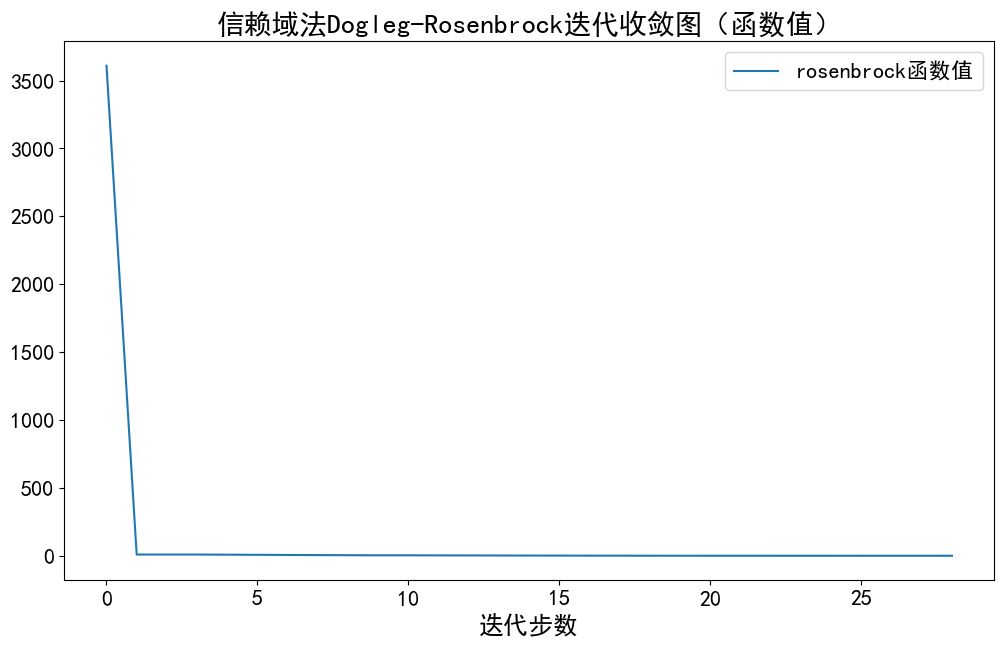

In [11]:
fig = plt.figure(figsize=(12, 7))
plt.plot(y_list_trust)
plt.title("信赖域法Dogleg-Rosenbrock迭代收敛图（函数值）", fontsize=20)
plt.xlabel("迭代步数", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(['rosenbrock函数值'], fontsize=16)
plt.savefig('pic/dogleg_y.png', dpi=1000, bbox_inches='tight')

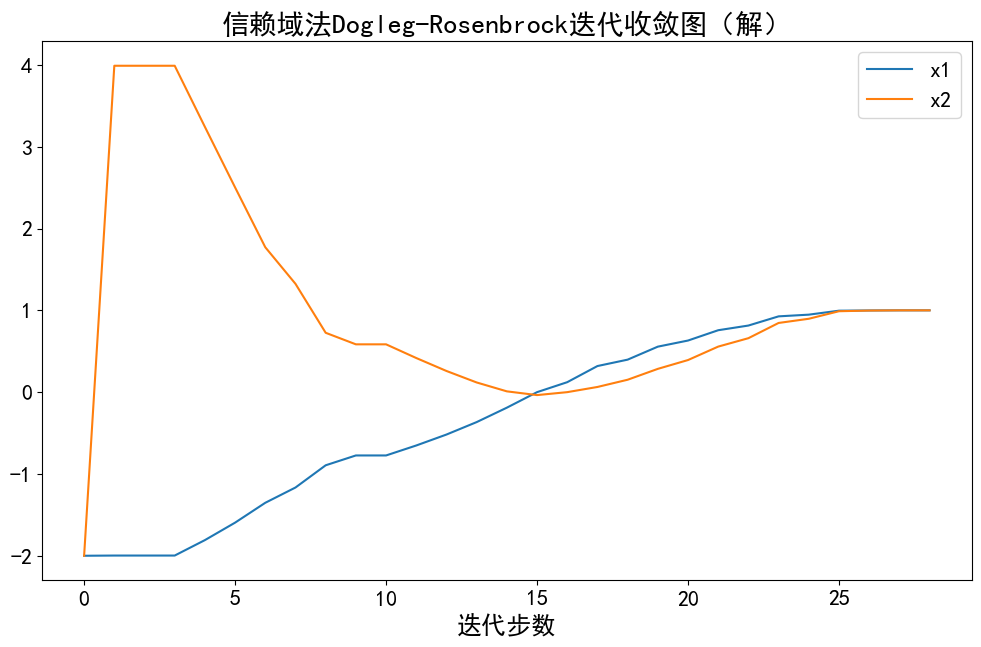

In [12]:
fig = plt.figure(figsize=(12, 7))
plt.plot(x_list_trust)
plt.title("信赖域法Dogleg-Rosenbrock迭代收敛图（解）", fontsize=20)
plt.xlabel("迭代步数", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(['x1', 'x2'], fontsize=16)
plt.savefig('pic/dogleg_x.png', dpi=1000, bbox_inches='tight')

### （5）共轭梯度

In [13]:
def conjugate_gradient(func, x, beta_method='FR', reset=6, epsilon=1e-4):
    x_list = [x]
    y_list = [func(x)]
    grad_f = grad(func)
    iter_count = 0
    p = -grad_f(x)
    while np.linalg.norm(grad_f(x)) >= epsilon:
        alpha = back_search(func=func, x=x, d=p, step=1)
        x_new = x + alpha*p
        
        if iter_count % reset == 0:
            beta = 0
        else:
            if beta_method == 'FR':
                beta = (np.linalg.norm(grad_f(x_new))**2)/(np.linalg.norm(grad_f(x))**2)
            elif beta_method == 'HS':
                beta = (np.dot(grad_f(x_new), (grad_f(x_new)-grad_f(x))))/(np.dot((grad_f(x_new)-grad_f(x)), p))
            elif beta_method == 'PR':
                beta = (np.dot(grad_f(x_new), (grad_f(x_new)-grad_f(x))))/(np.linalg.norm(grad_f(x))**2)

            beta = max(beta, 0)
        
        p = -grad_f(x_new) + beta*p
        x = x_new
        iter_count = iter_count + 1
        x_list.append(x)
        y_list.append(func(x))
    
    return x_list, y_list
    


In [14]:
x_list_frcg, y_list_frcg = conjugate_gradient(func=rosenbrock, x=x0, beta_method='FR')

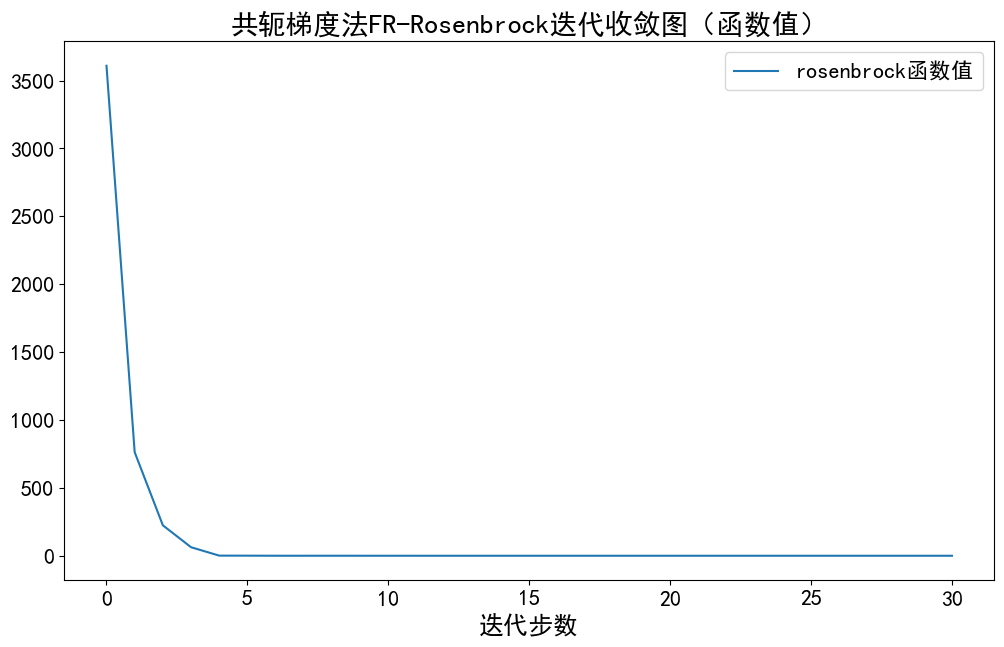

In [15]:
fig = plt.figure(figsize=(12, 7))
plt.plot(y_list_frcg)
plt.title("共轭梯度法FR-Rosenbrock迭代收敛图（函数值）", fontsize=20)
plt.xlabel("迭代步数", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(['rosenbrock函数值'], fontsize=16)
plt.savefig('pic/cg_FR_y.png', dpi=1000, bbox_inches='tight')

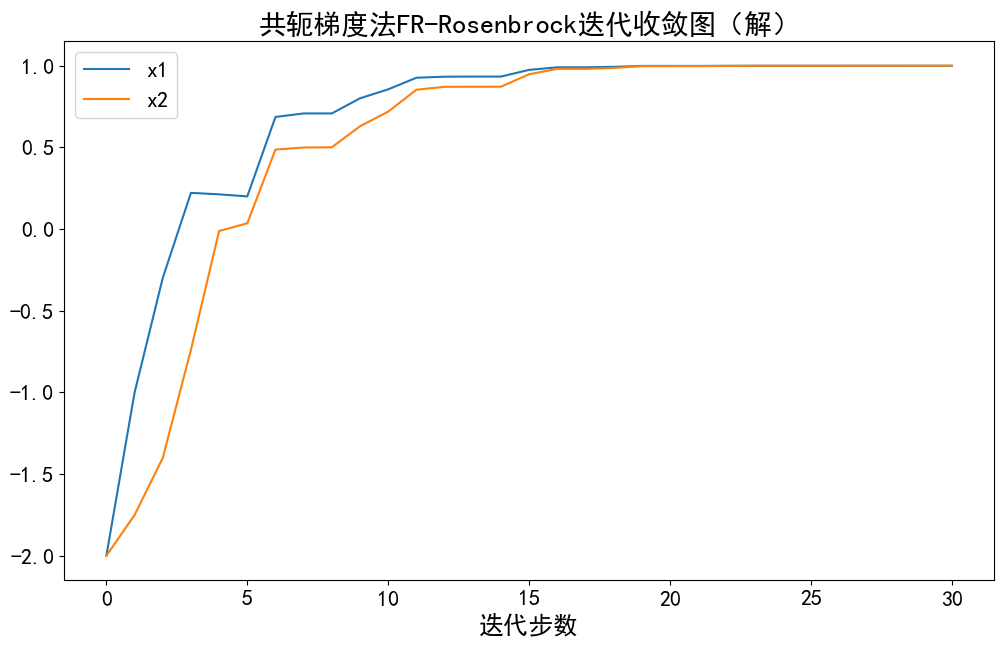

In [16]:
fig = plt.figure(figsize=(12, 7))
plt.plot(x_list_frcg)
plt.title("共轭梯度法FR-Rosenbrock迭代收敛图（解）", fontsize=20)
plt.xlabel("迭代步数", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(['x1', 'x2'], fontsize=16)
plt.savefig('pic/cg_FR_x.png', dpi=1000, bbox_inches='tight')

In [17]:
x_list_prcg, y_list_prcg = conjugate_gradient(func=rosenbrock, x=x0, beta_method='PR')

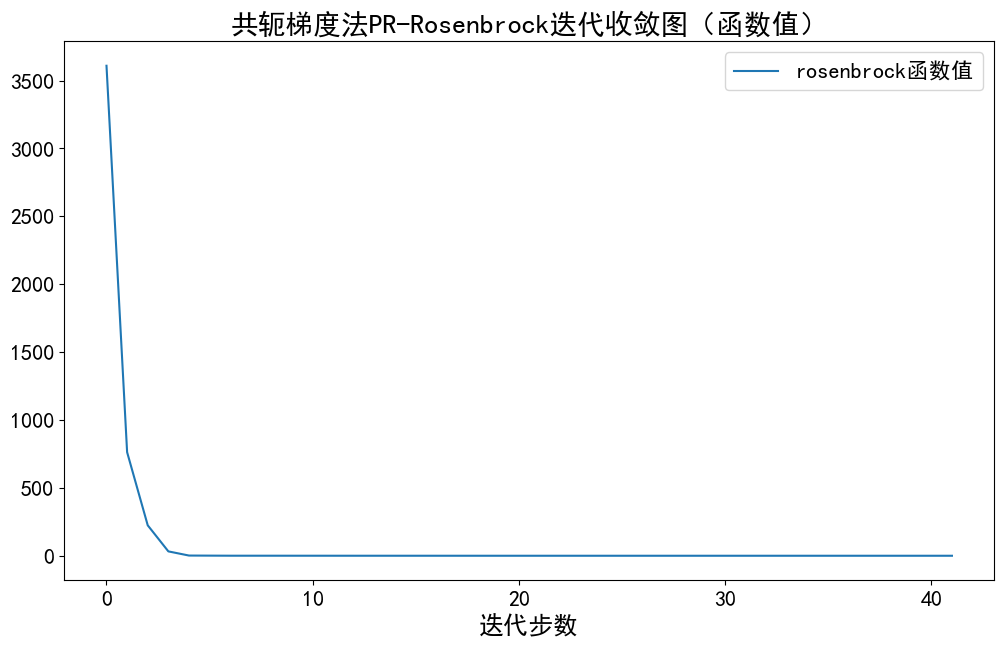

In [18]:
fig = plt.figure(figsize=(12, 7))
plt.plot(y_list_prcg)
plt.title("共轭梯度法PR-Rosenbrock迭代收敛图（函数值）", fontsize=20)
plt.xlabel("迭代步数", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(['rosenbrock函数值'], fontsize=16)
plt.savefig('pic/cg_PR_y.png', dpi=1000, bbox_inches='tight')

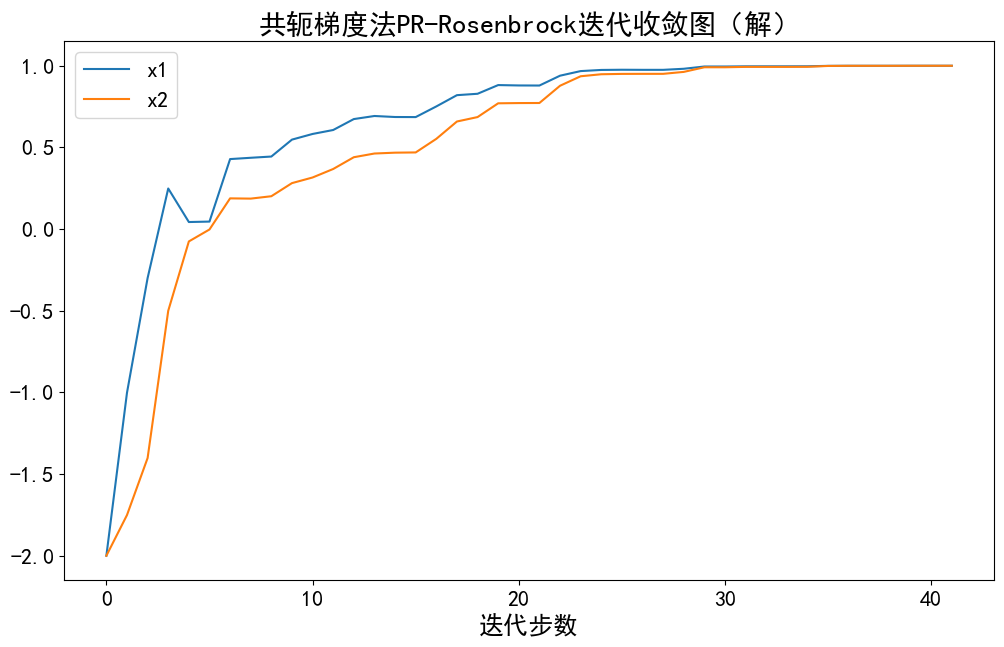

In [19]:
fig = plt.figure(figsize=(12, 7))
plt.plot(x_list_prcg)
plt.title("共轭梯度法PR-Rosenbrock迭代收敛图（解）", fontsize=20)
plt.xlabel("迭代步数", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(['x1', 'x2'], fontsize=16)
plt.savefig('pic/cg_PR_x.png', dpi=1000, bbox_inches='tight')

In [20]:
x_list_hscg, y_list_hscg = conjugate_gradient(func=rosenbrock, x=x0, beta_method='HS')

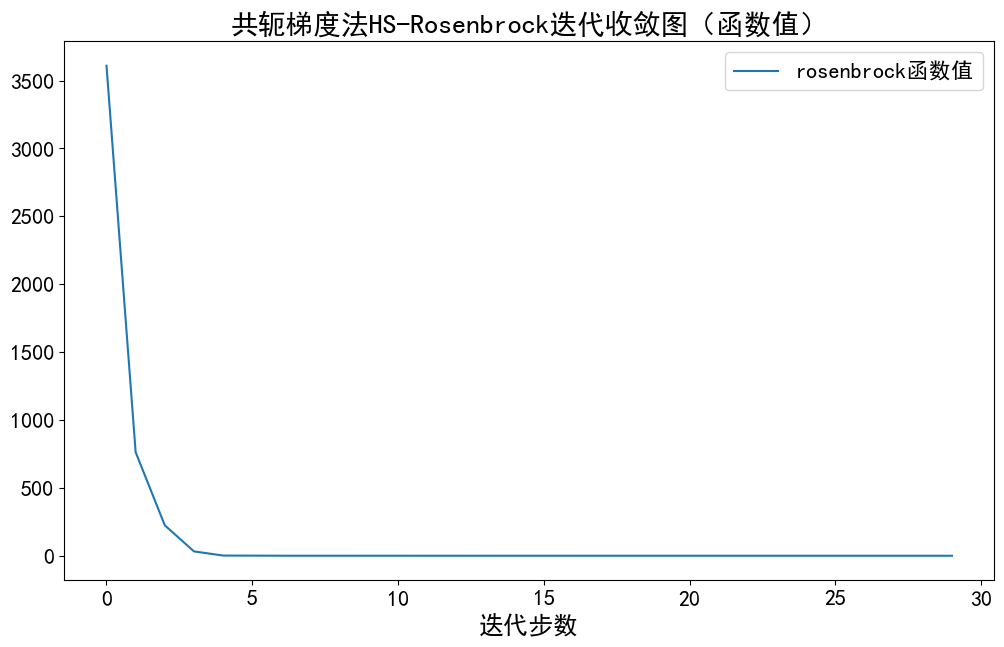

In [21]:
fig = plt.figure(figsize=(12, 7))
plt.plot(y_list_hscg)
plt.title("共轭梯度法HS-Rosenbrock迭代收敛图（函数值）", fontsize=20)
plt.xlabel("迭代步数", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(['rosenbrock函数值'], fontsize=16)
plt.savefig('pic/cg_HS_y.png', dpi=1000, bbox_inches='tight')

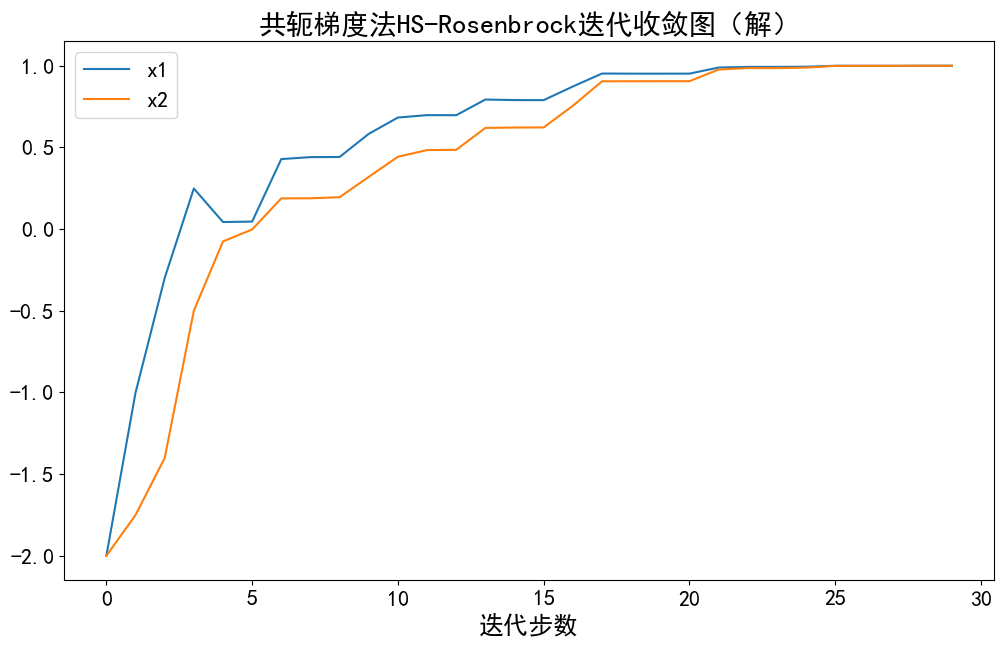

In [22]:
fig = plt.figure(figsize=(12, 7))
plt.plot(x_list_hscg)
plt.title("共轭梯度法HS-Rosenbrock迭代收敛图（解）", fontsize=20)
plt.xlabel("迭代步数", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(['x1', 'x2'], fontsize=16)
plt.savefig('pic/cg_HS_x.png', dpi=1000, bbox_inches='tight')

## HW4

### （1）罚函数法-Q2

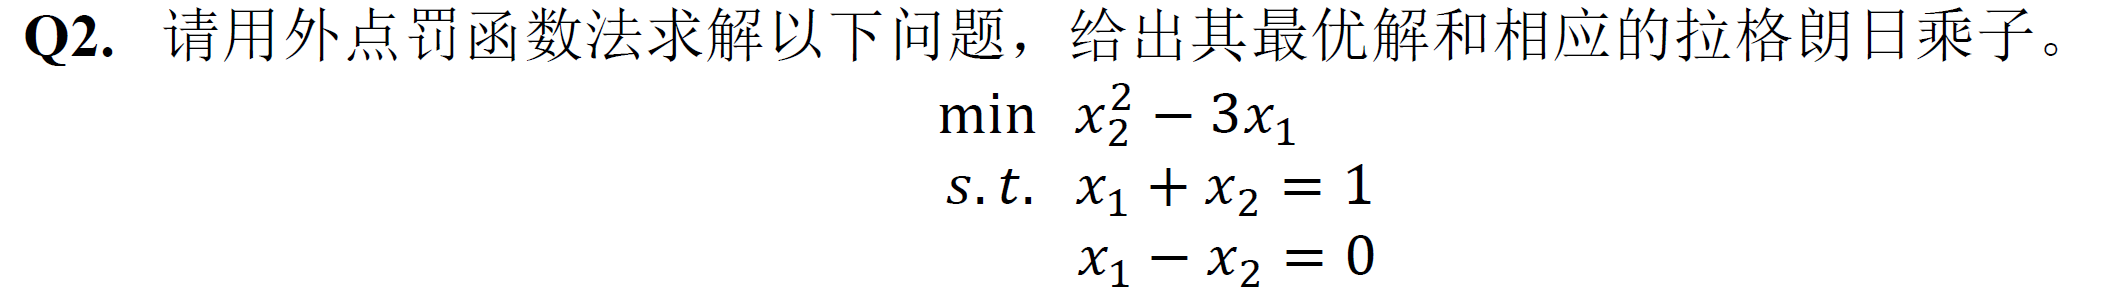

In [23]:
def objective_func_hw4_1(x):
    obj = x[1]**2 - 3*x[0]
    return obj

def eq_con_1_hw4_1(x):
    return x[0] + x[1] - 1

def eq_con_2_hw4_1(x):
    return x[0] - x[1]

In [24]:
# def exterior_penalty_method(x0, rho_init=1, rho_increase=5, epsilon=1e-6, gd_epsilon=1e-6):
#     rho = rho_init
#     x = x0
#     penalty_value = penalty_func(x)
#     x_list = [x]
#     y_list = [objective_func(x)]

#     while penalty_value >= epsilon:
#         # 梯度下降求解
#         grad_f = grad(objective_penalty_func)
#         x_gd = x.copy()
#         # print(grad_f(x_gd, rho))
#         while np.linalg.norm(grad_f(x_gd, rho)) >= gd_epsilon:
#             d = -grad_f(x_gd, rho)
#             # 回退线搜索
#             step = 1
#             c = 0.5
#             beta = 0.8
#             while objective_penalty_func(x_gd+step*d, rho) >= objective_penalty_func(x_gd, rho)+c*step*np.dot(grad_f(x_gd, rho).T, d):
#                 step = step*beta

#             x_gd = x_gd + step*d

#         x = x_gd
#         penalty_value = penalty_func(x)
#         rho = rho*rho_increase

#         x_list.append(x)
#         y_list.append(objective_func(x))
    
#     return x_list, y_list


In [25]:
def exterior_penalty_method(obj_func, eq_cons, x0, rho_init=1, rho_increase=5, epsilon=1e-6, gd_epsilon=1e-4, max_iter=1000):
    rho_penalty = rho_init
    x = x0
    x_list = [x]
    y_list = [obj_func(x)]

    for i in range(max_iter):
        def penalty_func(x):
            return sum(
                [1/2*rho_penalty*eq(x)**2 for eq in eq_cons]
            )

        def objective_penalty_func(x):
            obj = obj_func(x)
            penalty = penalty_func(x)
            return obj + penalty
        
        # 梯度下降求解
        x_gd = x.copy()
        x_gd_list, _ = gradient_descent_back(objective_penalty_func, x_gd, epsilon=gd_epsilon)
        
        x = x_gd_list[-1]

        penalty_value = penalty_func(x)
        rho_penalty = rho_penalty*rho_increase

        x_list.append(x)
        y_list.append(obj_func(x))

        if penalty_value < epsilon:
            return x_list, y_list
    
    return x_list, y_list

In [26]:
x_0_hw4_1 = np.array([0.0, 0.0])

eq_cons_hw4_1 = [eq_con_1_hw4_1, eq_con_2_hw4_1]

x_list_penalty, y_list_penalty = exterior_penalty_method(objective_func_hw4_1, eq_cons_hw4_1, x_0_hw4_1)

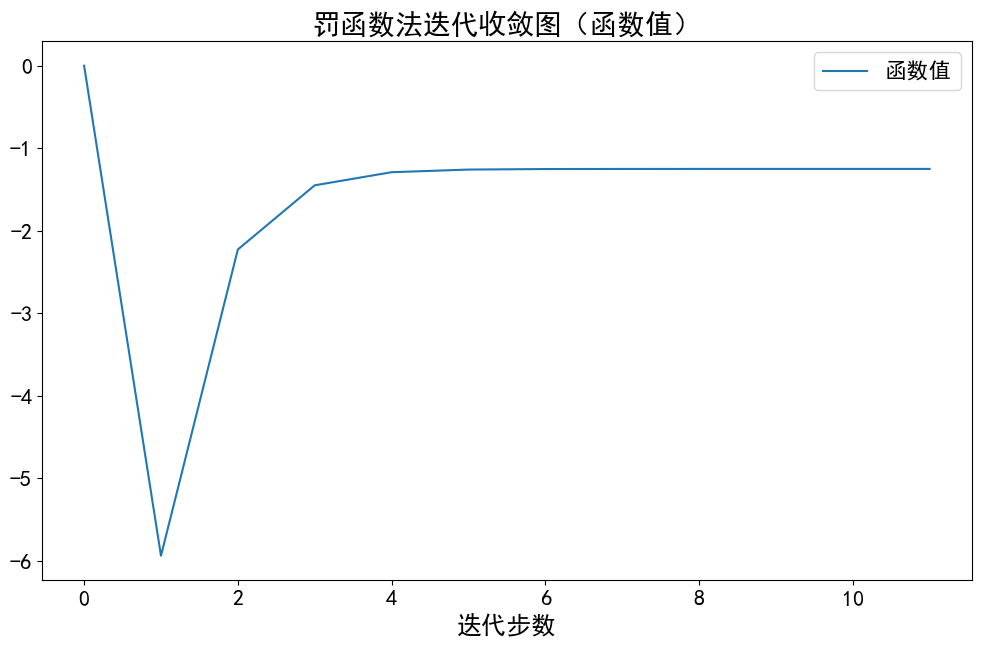

In [27]:
fig = plt.figure(figsize=(12, 7))
plt.plot(y_list_penalty)
plt.title("罚函数法迭代收敛图（函数值）", fontsize=20)
plt.xlabel("迭代步数", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(['函数值'], fontsize=16)
plt.savefig('pic/penalty_y.png', dpi=1000, bbox_inches='tight')

In [28]:
y_list_penalty[-1]

np.float64(-1.2500005119983313)

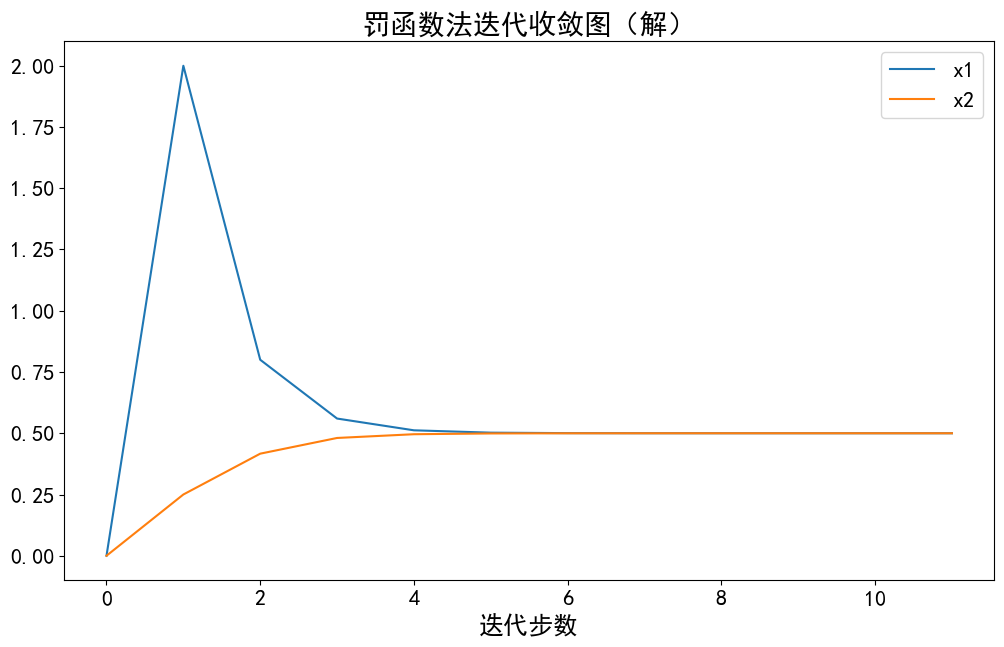

In [29]:
fig = plt.figure(figsize=(12, 7))
plt.plot(x_list_penalty)
plt.title("罚函数法迭代收敛图（解）", fontsize=20)
plt.xlabel("迭代步数", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(['x1', 'x2'], fontsize=16)
plt.savefig('pic/penalty_x.png', dpi=1000, bbox_inches='tight')

### （2）增广拉格朗日函数法-Q3

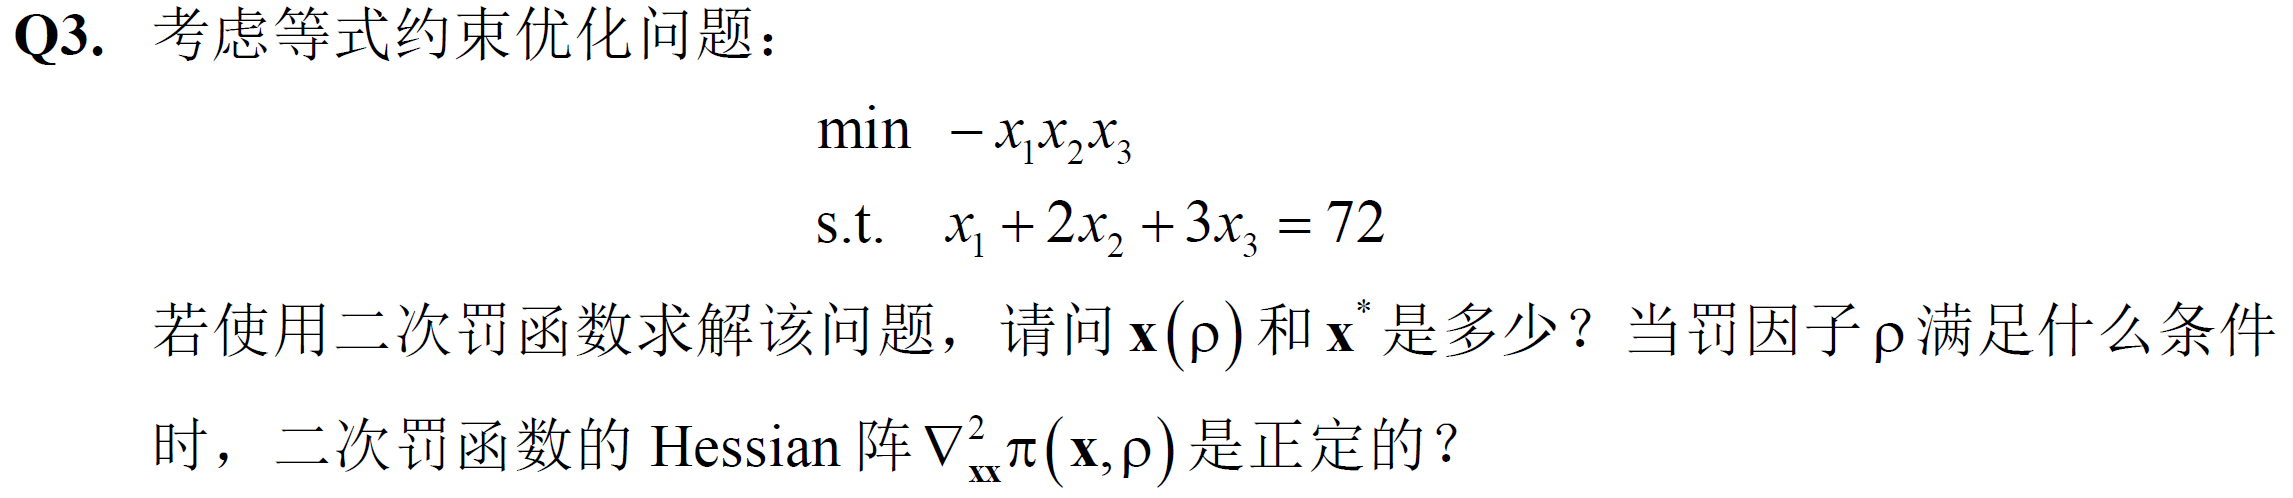

In [30]:
def objective_hw4_2(x):
    return -x[0]*x[1]*x[2]

def eq_con_1_hw4_2(x):
    return x[0] + 2*x[1] + 3*x[2] - 72

In [31]:
# def augmented_lagrangian_method(obj, g, x0, lambda_0, rho, step=0.01, epsilon=1e-6):
#     x = x0
#     lambda_ = lambda_0
#     x_list = [x]
#     y_list = [obj(x)]

#     while abs(g(x)) >= epsilon:
#         def augmented_lagrangian(x):
#             return obj(x) - lambda_*g(x) + 1/2*rho*g(x)**2
        
#         grad_al = grad(augmented_lagrangian)
        
#         while np.linalg.norm(grad_al(x)) >= epsilon:
#             d = -grad_al(x)
#             x = x + step*d

#         lambda_ = lambda_ - rho*g(x)

#         x_list.append(x)
#         y_list.append(obj(x))
    
#     return x_list, y_list

In [32]:
def gradient_descent(func, x, step=0.01, epsilon=1e-4):    
    grad_f = grad(func)
    x_list = [x]
    y_list = [func(x)]
    while np.linalg.norm(grad_f(x)) >= epsilon:
        d = -grad_f(x)
        x = x + step*d
        x_list.append(x)
        y_list.append(func(x))
    return x_list, y_list


def augmented_lagrangian_method(obj_func, eq_cons, x0, lambda_eq_0, rho, gd_step=0.01, epsilon=1e-6, gd_epsilon=1e-4, max_iter=1000):
    x = x0
    lambda_eq = lambda_eq_0
    x_list = [x]
    y_list = [obj_func(x)]

    for i in range(max_iter):
        def penalty_func(x):
            penalty_eq = sum(
                -lambda_eq[i]*eq(x) + 1/2*rho*eq(x)**2 for i, eq in enumerate(eq_cons)
            )
            return penalty_eq

        def augmented_lagrangian(x):
            obj = obj_func(x)
            penalty_eq = penalty_func(x)
            return obj + penalty_eq
        
        x_gd = x.copy()
        x_gd_list, _ = gradient_descent(augmented_lagrangian, x_gd, epsilon=gd_epsilon, step=gd_step)
        x = x_gd_list[-1]

        x_list.append(x)
        y_list.append(obj_func(x))

        eq_cons_result = np.array([eq(x) for eq in eq_cons])
        lambda_eq = lambda_eq - rho*eq_cons_result

        if np.linalg.norm(eq_cons_result) < epsilon:
            return x_list, y_list
    
    return x_list, y_list

In [33]:
x_0_hw4_2 = np.array([1.0, 2.0, 3.0])
lambda_eq_0_hw4_2 = [0.0]
rho_hw4_2 = 10

eq_cons_hw4_2 = [eq_con_1_hw4_2]

x_list_al, y_list_al = augmented_lagrangian_method(objective_hw4_2, eq_cons_hw4_2, x_0_hw4_2, lambda_eq_0_hw4_2, rho_hw4_2, gd_step=0.01, epsilon=1e-4)

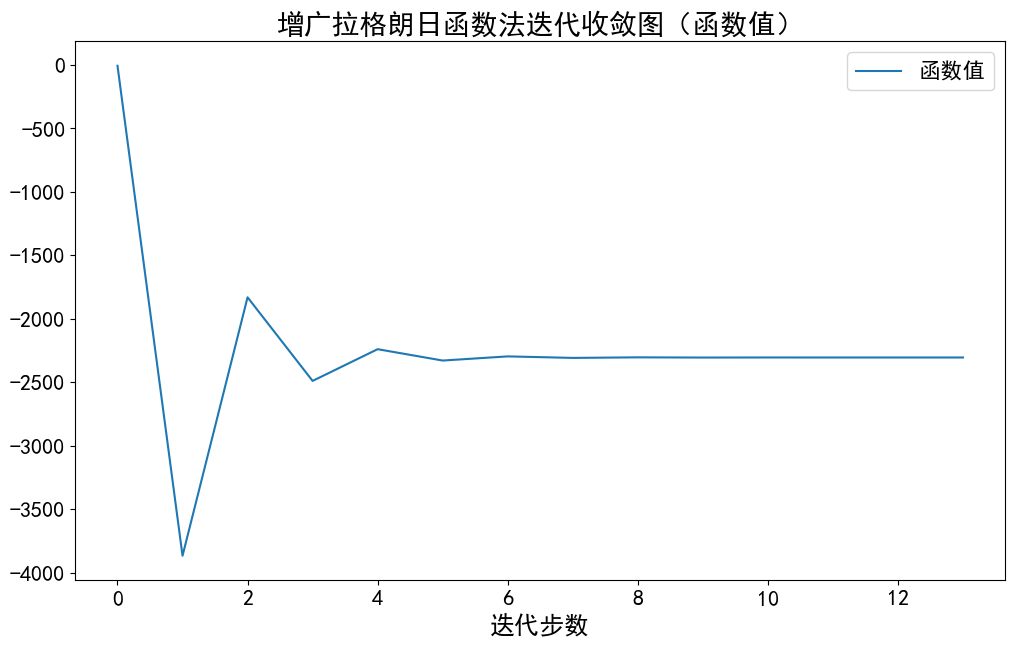

In [34]:
fig = plt.figure(figsize=(12, 7))
plt.plot(y_list_al)
plt.title("增广拉格朗日函数法迭代收敛图（函数值）", fontsize=20)
plt.xlabel("迭代步数", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(['函数值'], fontsize=16)
plt.savefig('pic/alm_y.png', dpi=1000, bbox_inches='tight')

In [35]:
y_list_al[-1]

np.float64(-2304.00623493457)

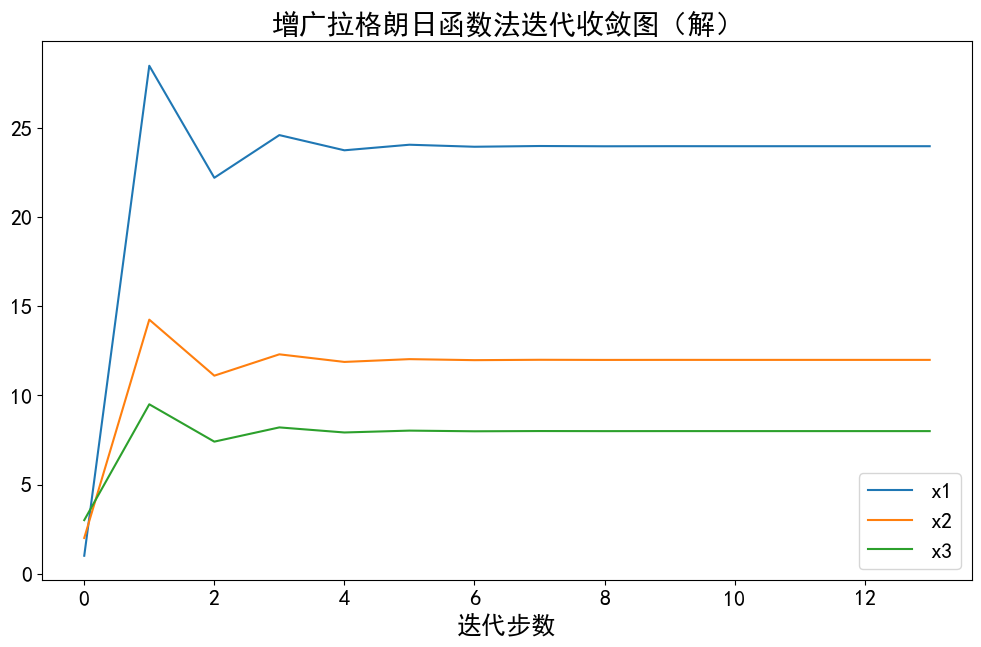

In [36]:
fig = plt.figure(figsize=(12, 7))
plt.plot(x_list_al)
plt.title("增广拉格朗日函数法迭代收敛图（解）", fontsize=20)
plt.xlabel("迭代步数", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(['x1', 'x2', 'x3'], fontsize=16)
plt.savefig('pic/alm_x.png', dpi=1000, bbox_inches='tight')

### （3）求解单调线性变分不等式-Q5

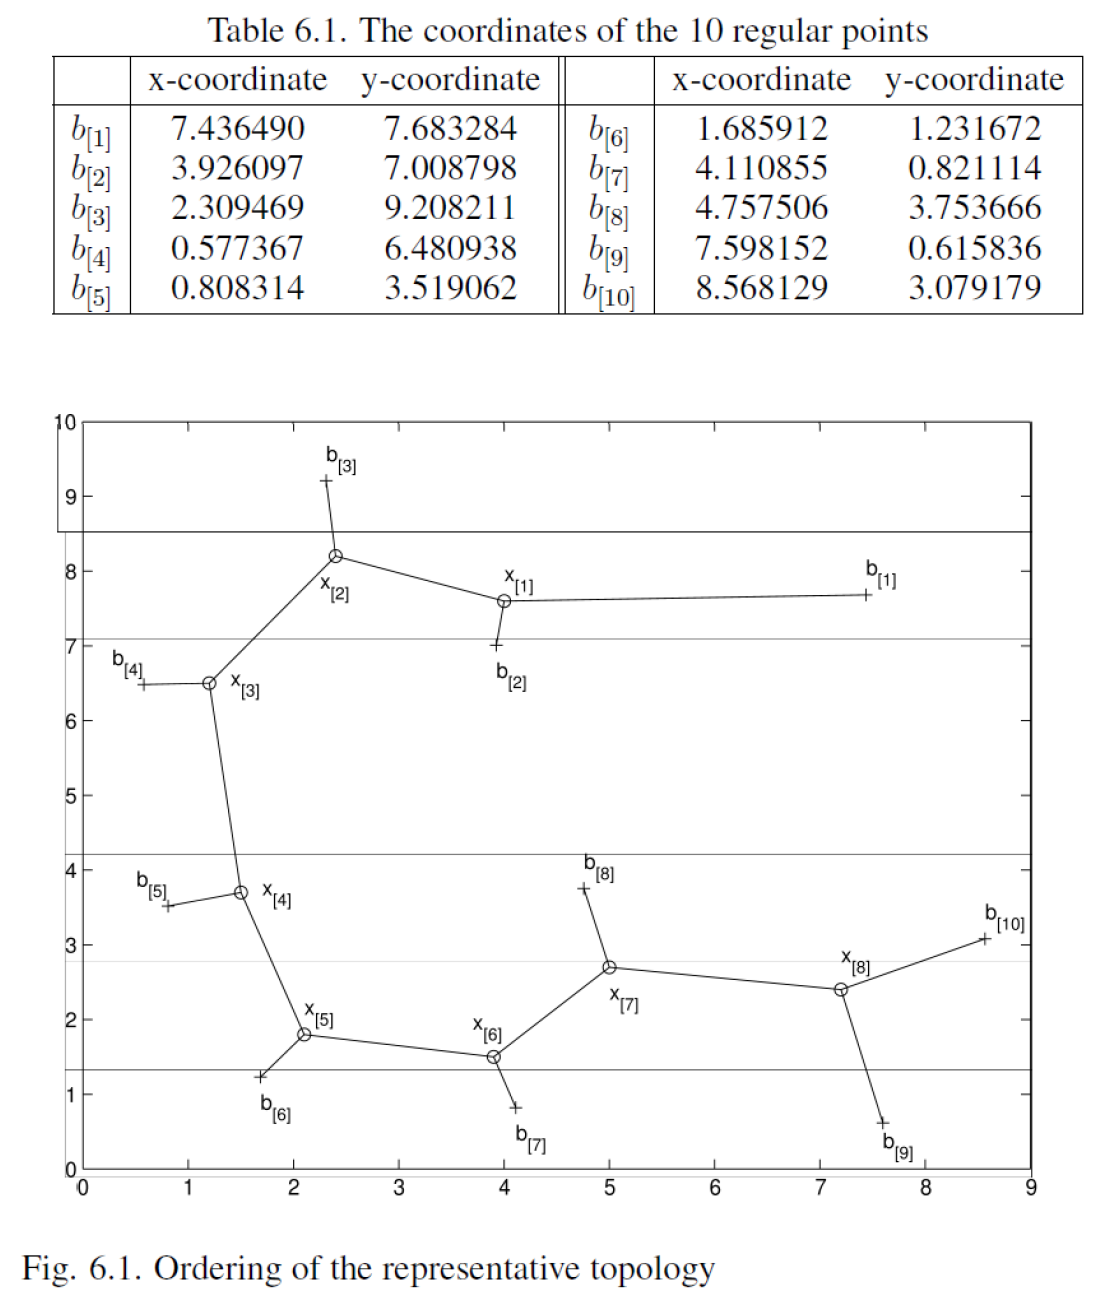

In [37]:
I_2 = np.eye(2)
O_2 = np.zeros((2,2))
b1 = np.array([7.436490, 7.683284])
b2 = np.array([3.926097, 7.008798])
b3 = np.array([2.309469, 9.208211])
b4 = np.array([0.577367, 6.480938])
b5 = np.array([0.808314, 3.519062])
b6 = np.array([1.685912, 1.231672])
b7 = np.array([4.110855, 0.821114])
b8 = np.array([4.757506, 3.753666])
b9 = np.array([7.598152, 0.615836])
b10 = np.array([8.568129, 3.079179])
vec_0 = np.array([0, 0])

A = np.block([
    [I_2, O_2, O_2, O_2, O_2, O_2, O_2, O_2],
    [I_2, O_2, O_2, O_2, O_2, O_2, O_2, O_2],
    [I_2, -I_2, O_2, O_2, O_2, O_2, O_2, O_2],
    [O_2, I_2, O_2, O_2, O_2, O_2, O_2, O_2],
    [O_2, I_2, -I_2, O_2, O_2, O_2, O_2, O_2],
    [O_2, O_2, I_2, O_2, O_2, O_2, O_2, O_2],
    [O_2, O_2, I_2, -I_2, O_2, O_2, O_2, O_2],
    [O_2, O_2, O_2, I_2, O_2, O_2, O_2, O_2],
    [O_2, O_2, O_2, I_2, -I_2, O_2, O_2, O_2],
    [O_2, O_2, O_2, O_2, I_2, O_2, O_2, O_2],
    [O_2, O_2, O_2, O_2, I_2, -I_2, O_2, O_2],
    [O_2, O_2, O_2, O_2, O_2, I_2, O_2, O_2],
    [O_2, O_2, O_2, O_2, O_2, I_2, -I_2, O_2],
    [O_2, O_2, O_2, O_2, O_2, O_2, I_2, O_2],
    [O_2, O_2, O_2, O_2, O_2, O_2, I_2, -I_2],
    [O_2, O_2, O_2, O_2, O_2, O_2, O_2, I_2],
    [O_2, O_2, O_2, O_2, O_2, O_2, O_2, I_2]
]) 
b = np.block(
    [
        [b1.reshape(-1, 1)],
        [b2.reshape(-1, 1)],
        [vec_0.reshape(-1, 1)],
        [b3.reshape(-1, 1)],
        [vec_0.reshape(-1, 1)],
        [b4.reshape(-1, 1)],
        [vec_0.reshape(-1, 1)],
        [b5.reshape(-1, 1)],
        [vec_0.reshape(-1, 1)],
        [b6.reshape(-1, 1)],
        [vec_0.reshape(-1, 1)],
        [b7.reshape(-1, 1)],
        [vec_0.reshape(-1, 1)],
        [b8.reshape(-1, 1)],
        [vec_0.reshape(-1, 1)],
        [b9.reshape(-1, 1)],
        [b10.reshape(-1, 1)],
    ]
)
M = np.block(
    [
        [np.zeros((A.shape[1], A.shape[1])), A.T],
        [-A, np.zeros((A.shape[0], A.shape[0]))] 
    ]
)
vec_0_q = np.zeros((M.shape[0]-b.shape[0], 1))
q = np.block(
    [
        [vec_0_q],
        [b]
    ]
)

def projection_R_Binf(u, x_size):
    for i in range(x_size, len(u)):
        u[i] = max(-1, min(u[i], 1))
    return u

def objective_l1(x):
    return np.linalg.norm(A@x-b, ord=1)

def PC_FI1_V(u, M, q, x_size, gamma=1.8, beta=1, max_iter=10000, epsilon=1e-6):
    x = u[:x_size]
    x_list = [x]
    y_list = [objective_l1(x)]
    for i in range(max_iter):
        e = u - projection_R_Binf(u-(M@u+q), x_size)
        d = M.T@e + M@u+q
        alpha = (np.linalg.norm(e, ord=2)**2)/(np.linalg.norm((np.eye(M.T.shape[0])+M.T)@e, ord=2)**2)
        u = projection_R_Binf(u - gamma*alpha*d, x_size)

        if np.sqrt(alpha) >= 0.6:
            beta = 3/2*beta
        elif np.sqrt(alpha) <= 0.3:
            beta = 2/3*beta
        
        M = beta*M
        q = beta*q

        x = u[:x_size]
        x_list.append(x)
        y_list.append(objective_l1(x))

        if np.linalg.norm(e, ord=1) <= epsilon:
            return x_list, y_list
    
    return x_list, y_list


In [38]:
x_size = 16
y_size = 34
u0 = np.zeros((x_size + y_size, 1))

x_list_vi, y_list_vi = PC_FI1_V(u0, M, q, x_size, epsilon=1e-10)

In [39]:
len(y_list_vi)

78

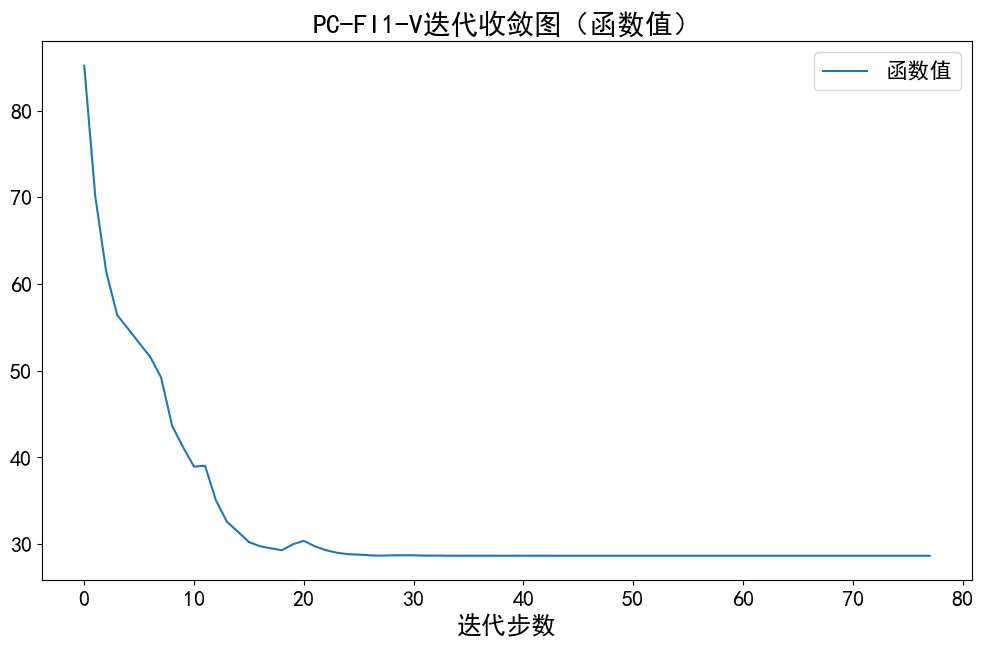

In [40]:
fig = plt.figure(figsize=(12, 7))
plt.plot(y_list_vi)
plt.title("PC-FI1-V迭代收敛图（函数值）", fontsize=20)
plt.xlabel("迭代步数", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(['函数值'], fontsize=16)
plt.savefig('pic/vi_y.png', dpi=1000, bbox_inches='tight')

In [41]:
x_final = x_list_vi[-1]

x_final_x = x_final[::2]
x_final_y = x_final[1::2]

b_all = np.block(
    [
        [b1.reshape(-1, 1)],
        [b2.reshape(-1, 1)],
        [b3.reshape(-1, 1)],
        [b4.reshape(-1, 1)],
        [b5.reshape(-1, 1)],
        [b6.reshape(-1, 1)],
        [b7.reshape(-1, 1)],
        [b8.reshape(-1, 1)],
        [b9.reshape(-1, 1)],
        [b10.reshape(-1, 1)],
    ]
)

b_all_x = b_all[::2]
b_all_y = b_all[1::2]

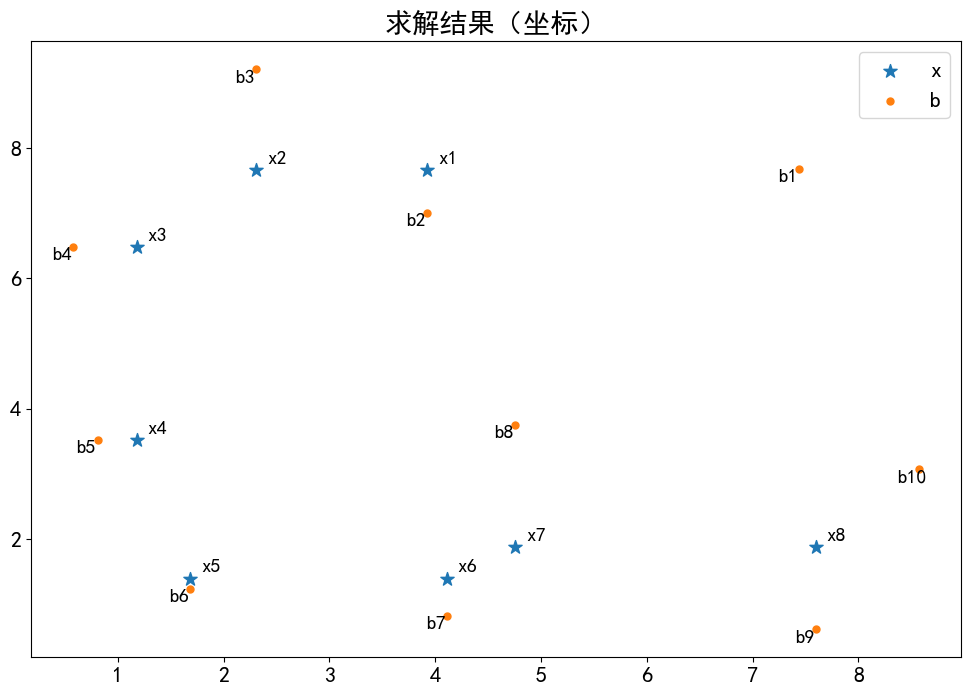

In [42]:
fig = plt.figure(figsize=(12, 8))
x_text = ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8']
plt.scatter(x_final_x, x_final_y, marker='*', s=100)
for i in range(len(x_text)):
    plt.annotate(x_text[i], xy = (x_final_x[i], x_final_y[i]), xytext = (x_final_x[i]+0.1, x_final_y[i]+0.1), fontsize=14)

b_text = ['b1', 'b2', 'b3', 'b4', 'b5', 'b6', 'b7', 'b8', 'b9', 'b10']
plt.scatter(b_all_x, b_all_y, marker='.', s=100)
for i in range(len(b_text)):
    plt.annotate(b_text[i], xy = (b_all_x[i], b_all_y[i]), xytext = (b_all_x[i]-0.2, b_all_y[i]-0.2), fontsize=14)
plt.legend(['x', 'b'], fontsize=16)
plt.title('求解结果（坐标）', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig('pic/vi_x.png', dpi=1000, bbox_inches='tight')

In [43]:
y_list_vi[-1]

np.float64(28.66585800001403)